In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=700
    LIMIT=100
    #CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    #CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    #VERSION = '20180605' # Foursquare API version
    CLIENT_ID = 'F35TI42CRIN5DG5MNZGIWUCZ025JMLBFUBYUXSQKDJMES35V' # your Foursquare ID
    CLIENT_SECRET = 'GP4VETLF43FNTL00CKNW110FBKQ50CCUX0OMALU4OGJZ53Q2' # your Foursquare Secret
    VERSION = '20180604'
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [5]:
def get_venue_details(venue_id):
        
    #CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    #CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    #VERSION = '20180605' # Foursquare API version
    CLIENT_ID = 'F35TI42CRIN5DG5MNZGIWUCZ025JMLBFUBYUXSQKDJMES35V' # your Foursquare ID
    CLIENT_SECRET = 'GP4VETLF43FNTL00CKNW110FBKQ50CCUX0OMALU4OGJZ53Q2' # your Foursquare Secret
    VERSION = '20180604'
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [7]:
# get new york data
new_york_data=get_new_york_data()

new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

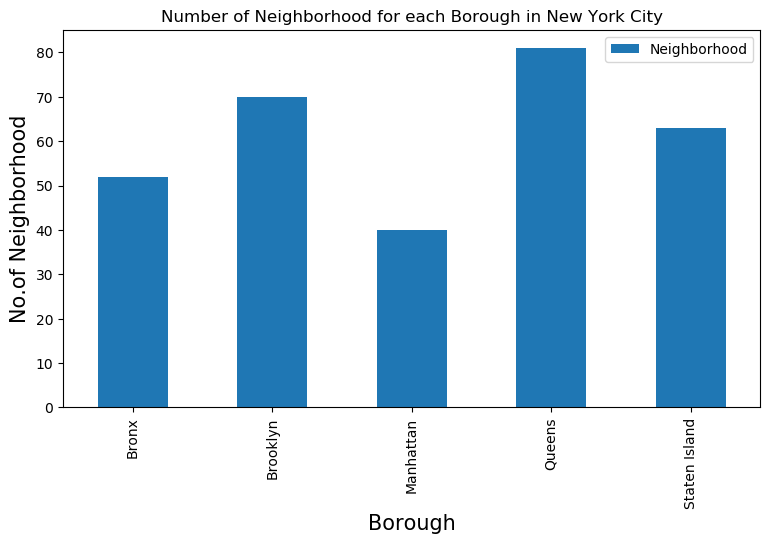

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Italian restaurants for each Neighborhood

In [11]:
# prepare neighborhood list that contains Italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Italian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Italian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Italian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Italian Restaurants in Riverdale, Bronx:1
( 6 / 306 ) Italian Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Italian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Restaurants in Woodlawn, Bronx:2
( 9 / 306 ) Italian Restaurants in Norwood, Bronx:0
( 10 / 306 ) Italian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Restaurants in Baychester, Bronx:0
( 12 / 306 ) Italian Restaurants in Pelham Parkway, Bronx:2
( 13 / 306 ) Italian Restaurants in City Island, Bronx:2
( 14 / 306 ) Italian Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Italian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Italian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Restaurants in Fordham, Bronx:0
( 18 / 306 ) Italian Restaurants in Ea

Now that we have got all the Italian restaurants in new york city , we will analyze it

In [12]:
italian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
2,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge
3,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's
4,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta


In [14]:
italian_rest_ny.shape

(383, 4)

We got 383 Italian Resturants across New York City

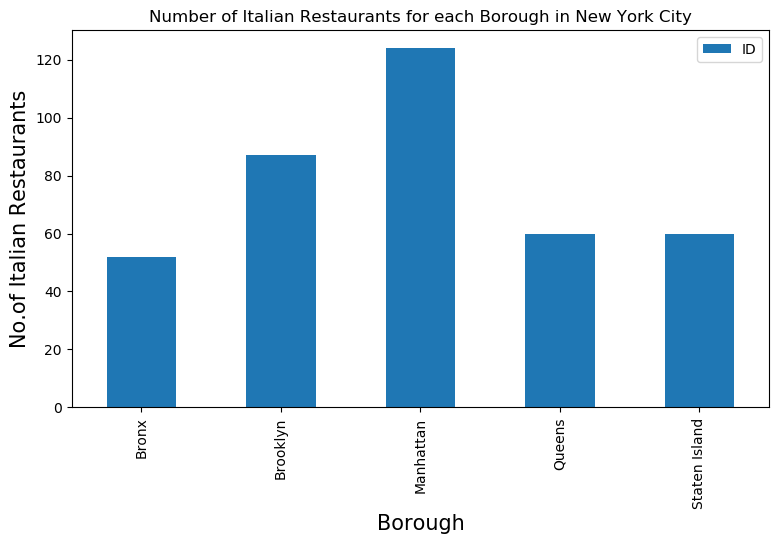

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Manhattan has the largest number of Italian restaurants

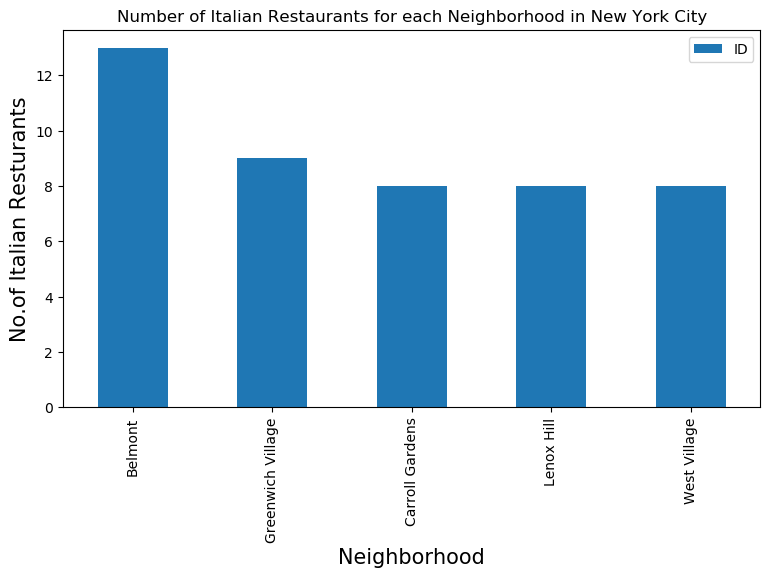

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [17]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
19,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
20,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
21,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
22,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
23,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
24,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
25,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
26,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato
27,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
28,Bronx,Belmont,4a8e261cf964a5201c1220e3,Roberto's


So Belmont in Bronx has the highest number of Italian Restaurants with a total count of 13.

Now we will get the ranking of each restaurant for further analysis.

In [18]:
# prepare neighborhood list that contains Italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     7.3     4
( 1 / 383 ) processed
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.5    14
( 2 / 383 ) processed
                         ID         Name  Likes  Rating  Tips
0  4d3cb3026b3d236a066a6364  Rivers Edge     10     6.8     8
( 3 / 383 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bf96ae65317a593d837017f  Enzo's     26     8.7    11
( 4 / 383 ) processed
                         ID         Name  Likes  Rating  Tips
0  4b47f069f964a5208c4426e3  Pasta Pasta      9     6.2     8
( 5 / 383 ) processed
                         ID                       Name  Likes  Rating  Tips
0  4514ed4df964a520e5391fe3  Artie's Steak and Seafood     44     8.3    27
( 6 / 383 ) processed
                         ID                      Name  Likes  Rati

In [19]:
italian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,7.3,4
1,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.5,14
2,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.8,8
3,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's,26,8.7,11
4,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta,9,6.2,8


In [20]:
italian_rest_stats_ny.shape

(383, 7)

In [21]:
italian_rest_ny.shape

(383, 4)

So we got data for all restaurants,save this data to a csv sheet.As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [22]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [23]:
italian_rest_stats_ny_csv=pd.read_csv('italian_rest_stats_ny.csv')

In [24]:
italian_rest_stats_ny_csv.shape

(383, 7)

In [25]:
italian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,7.3,4
1,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.5,14
2,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.8,8
3,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's,26,8.7,11
4,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta,9,6.2,8


In [26]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 7 columns):
Borough         383 non-null object
Neighborhood    383 non-null object
ID              383 non-null object
Name            383 non-null object
Likes           383 non-null object
Rating          383 non-null float64
Tips            383 non-null object
dtypes: float64(1), object(6)
memory usage: 21.0+ KB


In [27]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')


In [28]:
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')

In [29]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 7 columns):
Borough         383 non-null object
Neighborhood    383 non-null object
ID              383 non-null object
Name            383 non-null object
Likes           383 non-null float64
Rating          383 non-null float64
Tips            383 non-null float64
dtypes: float64(3), object(4)
memory usage: 21.0+ KB


In [32]:
# Resturant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              4cc6222106c25481d7a4a047
Name                 Rubirosa Ristorante
Likes                               2466
Rating                               9.4
Tips                                 823
Name: 196, dtype: object

In [33]:
# Resturant with maximum Rating
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a98aed16a59506d7a60d67c
Name                          Carmenta’s
Likes                                 51
Rating                               9.5
Tips                                  21
Name: 71, dtype: object

In [34]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 21
Rating                               8.5
Tips                                1136
Name: 277, dtype: object

Now lets visualize neighborhood with maximum average rating of restaurants

In [35]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']


In [36]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
19,Bushwick,9.500000
38,Downtown,9.200000
15,Boerum Hill,9.200000
119,Soho,9.025000
94,Noho,9.000000
61,Hamilton Heights,9.000000
60,Greenwich Village,8.977778
74,Little Italy,8.950000
96,North Side,8.900000
139,West Village,8.875000


Above are the top neighborhoods with top average rating of Italian restaurants

In [37]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [40]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.481452
1,Brooklyn,7.758621
3,Queens,7.368333
0,Bronx,7.246154
4,Staten Island,6.048333


Similarly these are the average rating of Itaian Restaurants for each Borough

Lets visualize it

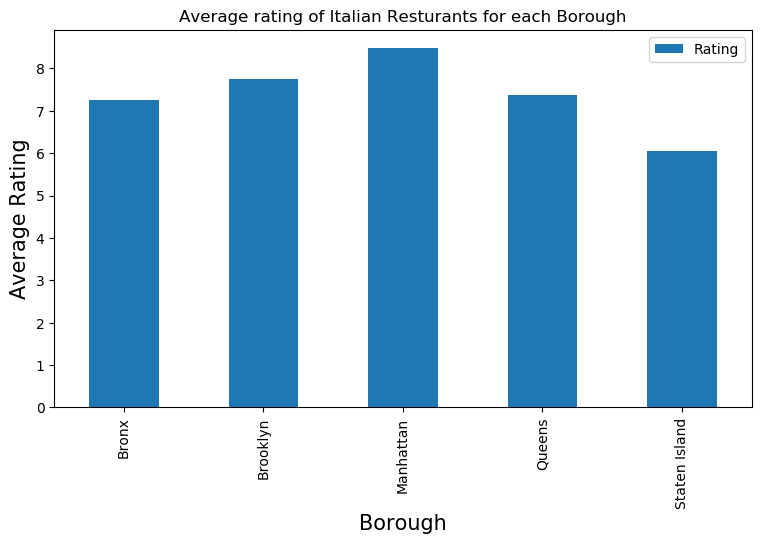

In [41]:
plt.figure(figsize=(9,5), dpi = 100)
# titledian
plt.title('Average rating of Italian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal to 9.0 to visualize on map



In [42]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [43]:
ny_neighborhood_stats

,Neighborhood,Average Rating
15,Boerum Hill,9.200
19,Bushwick,9.500
38,Downtown,9.200
61,Hamilton Heights,9.000
94,Noho,9.000
119,Soho,9.025


We will join this dataset to original new york data to get longitude and latitude

In [44]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [46]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,9.200
1,Brooklyn,Bushwick,40.698116,-73.925258,9.500
2,Brooklyn,Downtown,40.690844,-73.983463,9.200
3,Manhattan,Hamilton Heights,40.823604,-73.949688,9.000
4,Manhattan,Noho,40.723259,-73.988434,9.000
5,Manhattan,Soho,40.722184,-74.000657,9.025


Now we will show this data on a map

In [47]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [48]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [49]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [50]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)